In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from typing import Tuple ,Optional,Dict
from datetime import datetime
from dataclasses import dataclass
import textwrap
import logging

In [2]:
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('eda_sentiment_analysis.log'),
        logging.StreamHandler()
    ]

)
logger = logging.getLogger(__name__)

In [3]:
@dataclass
class Config:
    """Configuration Parameters for EDA pipeline"""
    RAW_DATA_PATH: str='../data/raw/sentiment_comments.csv'
    PROCESSED_DATA_PATH: str='../data/processed/processed_sentiments.csv'
    PLOT_DIR: str='../plots/'
    REPORT_DIR: str='../reports/'
    FIGURE_SIZE: Tuple[int,int]=(10,8)
    PALETTE:str='viridis'
    SEED:int=42
config=Config()

In [4]:
#UTILITY FUNCTION
def check_directory(file_path:str)->None:
    """
        Ensures that directory exists if not then create one
    """
    try:
        if not os.path.exists(file_path):
            os.makedirs(file_path,exist_ok=True)
            logger.info(f"Directory Validated: {file_path}")
        else:
            logger.info(f"Directory Already exists: {file_path}")
    except Exception as e:
        logger.error(f"Error in creating the directory {file_path} : {str(e)}")
        raise

In [5]:
def setup_environment() ->None:
    """Initialise the analysis environment"""
    np.random.seed(config.SEED)
    sns.set(style='whitegrid',palette=config.PALETTE)
    plt.rcParams['figure.figsize']=config.FIGURE_SIZE
    check_directory(config.PLOT_DIR)
    check_directory(config.REPORT_DIR)
    check_directory(os.path.dirname(config.PROCESSED_DATA_PATH))


In [6]:
def load_validate_data(file_path: str) -> pd.DataFrame:
    """Load and validate dataset with comprehensive checks"""
    try:
        logger.info(f'Loading Data from {file_path}')
        df = pd.read_csv(file_path, parse_dates=['Comment_Date'])

        #Data Validataion
        logger.info(f"Performing data validation checks")

        #Check required columns 
        requried_columns = {
            'Username', 'Comment', 'Comment_Date',
            'Likes', 'Comment_Length', 'Has_Typo',
            'Slang_Presence', 'Sentiment'
        }
        missing_cols = requried_columns - set(df.columns)
        if missing_cols:
            raise ValueError(f'Missing required columns: {missing_cols}')

        #checks data types
        type_checks = {
            'Username': 'object', 
            'Comment': 'object', 
            'Comment_Date': 'datetime64[ns]',
            'Likes': 'int64', 
            'Comment_Length': 'int64', 
            'Has_Typo': 'int64',
            'Slang_Presence': 'int64', 
            'Sentiment': 'object'
        }
        for col, expected_type in type_checks.items():
            if not pd.api.types.is_dtype_equal(df[col].dtype, expected_type):
                raise ValueError(f'Column {col} has incorrect type.\nExpected {expected_type}, got {df[col].dtype}')


        #checks missing values
        if df.isnull().sum().sum() > 0:
            missing = df.isnull().sum()
            missing = missing[missing > 0]
            logger.warning(f'Missing values found:\n{missing}')
            #for production purpose, we would implement the imputation strategy here

        #Check date range validity
        current_year = datetime.now().year
        if not df['Comment_Date'].dt.year.isin([current_year - 1, current_year]).all():
            logger.warning("Some comment dates are outside the expected")

        #check sentiment categories
        valid_sentiments = {'Happy', 'Angry', 'Neutral', 'Sad', 'Excited'} 
        invalid_sentiments = set(df['Sentiment'].unique()) - valid_sentiments
        if invalid_sentiments:
            logger.warning(f'Unexpected sentiment categories found: {invalid_sentiments}')

        logger.info('Data validation is completed successfully')
        return df
    except Exception as e:
        logger.error(f'Data loading/validation failed: {str(e)}')

In [7]:
def feature_engineering(df:pd.DataFrame)->pd.DataFrame:
    '''create derived features from the raw data'''
    logger.info('Engineering additional features: ')

    #Temporal features
    #df['Comment_DayOfWeek']=df['Comment_Date'].dt.day_name()
    df['Comment_DayOfWeek'] = df['Comment_Date'].dt.day_name()
    df['Comment_Month'] = df['Comment_Date'].dt.month_name()
    df['Comment_Season'] = df['Comment_Date'].dt.month.map(
        {
            12: 'Winter', 1: 'Winter', 2: 'Winter',
            3: 'Spring', 4: 'Spring', 5: 'Summer',
            6: 'Summer', 7: 'Summer', 8: 'Rainy',
            9: 'Rainy', 10: 'Rainy', 11: 'Fall'
        }
    )

    #Text Complexity Features
    df['Words_per_Comment'] = df['Comment'].str.split().str.len()
    df['Avg_Word_Length'] = df['Comment'].str.split().apply(
        lambda x: np.mean([len(word) for word in x]) if x else 0
    )

    #engagement features
    df['Engagement_rate']=df['Likes']/df['Comment_Length']

    #sentiment Encoding
    sentiment_map = {'Angry': -2, 'Sad': -1, 'Neutral': 0, 'Happy': 1, 'Excited': 2}
    df['Sentiment_Score'] = df['Sentiment'].map(sentiment_map)

    logger.info('Feature Engineer Completed')
    return df
    



In [8]:
def plot_distributions(df: pd.DataFrame)->None:
    '''Create comprehensive plots for all numeric features'''
    logger.info("Creating the Distribution Plots")
    numeric_cols=df.select_dtypes(include=['int64','float64']).columns

    for col in numeric_cols:
        try:
            fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,5))

            #Histogram with KDE
            sns.histplot(df[col],kde=True,ax=ax1,bin=30,color='skyblue')
            ax1.set_title(f"Distribution of {col}")
            ax1.set_xlabel(col)
            ax1.set_ylabel('Frequesncy')

            #BOXPLOT
            sns.boxplot(x=df[col],ax=ax2,color='lightgreen')
            ax2.set_title(f"Boxplot of {col}")
            
            plt.tight_layout()
            save_plot(fig,f'distribution_{col}.png')
        
        except Exception as e:
            logger.error(f'Error plotting distribution for {col}: \n{str(e)}')

In [9]:
def plot_categorical_distribution(df:pd.DataFrame)->None:
    """Create comprehensive plots for categorical features."""
    logger.info('Creating comprehensive plots for the categorical features ')
    categorical_cols = ['Sentiment', 'Has_Typo', 'Slang_Presence', 'Comment_DayOfWeek', 'Comment_Month', 'Comment_Season']

    for col in categorical_cols:
        try:
            if col in df.columns:
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

                #Count plot
                sns.countplot(data=df, y=col, ax=ax1, order=df[col].value_counts().index)
                ax1.set_title(f"Count of {col}")
                ax1.set_xlabel('Count')
                ax1.set_ylabel(col)

                #Sentiment distributon within category
                if col != 'Sentiment':
                    sns.countplot(data=df, y=col, hue='Sentiment',ax=ax2)
                    ax2.set_title(f'Sentiment Distribution by {col}')
                    ax2.set_xlabel('Count')
                    ax2.set_ylabel(col)
                    ax2.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
                plt.tight_layout()
                save_plot(fig,f'categorical_{col}.png')

        except Exception as e:
            logger.error(f'Error plotting categorical analysis for {col}: {str(e)}')

In [10]:
def plot_temporal_analysis(df: pd.DataFrame) -> None:
    """Analyze trend over time"""
    logger.info('Creating temporal analysis plots')

    try:
        #resample by month
        temporal_df = df.set_index('Comment_Date')
        monthly = temporal_df.resample('M').agg(
            {
                'Likes': 'mean',
                'Comment_Length': 'mean',
                'Sentiment_Score': 'mean',
                'Username': 'count'
            }
        ).rename(columns={'Username': 'Comment_Count'})

        #create subplots
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))

        #plot 1: comment volume over time
        monthly['Comment_Count'].plot(ax=axes[0, 0], marker='o')
        axes[0, 0].set_title('Monthly Commment Volume')
        axes[0, 0].set_ylabel('Number of Comments')

        #plot2 : Average like over time
        monthly['Likes'].plot(ax=axes[0, 1], marker='o', color='green')
        axes[0, 1].set_title('Monthly Average Likes')
        axes[0, 1].set_ylabel('Average Likes')

        #plot3: average sentiment over time
        monthly['Sentiment_Score'].plot(ax=axes[1, 0], marker='o', color='orange')
        axes[1, 0].set_title("Monthly Average Sentiment Score")
        axes[1, 0].set_ylabel('Sentiment Score')

        #plt4L comment length overtime 
        monthly['Comment_Length'].plot(ax=axes[1, 1], marker='o', color='purple')
        axes[1, 1].set_title("Monthly Average Comment Length")
        axes[1, 1].set_ylabel("Average Length (chars)")


        plt.tight_layout()
        save_plot(fig, 'temporal_analysis.png')
    except Exception as e:
        logger.error(f"Error in temporal analysis: {str(e)}")

        

In [11]:
def plot_correlation_analysis(df: pd.DataFrame) -> None:
    """Perform comprehensive correlational analysis """
    logger.info('Creating correlational analysis')

    try:
        #Select numeric columns 
        numeric_df = df.select_dtypes(include=['int64', 'float64'])

        #correlational matrix
        corr = numeric_df.corr()

        #plot heatmap
        fig, ax = plt.subplots(figsize=(12, 10))
        sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, fmt='.2f', linewidth=0.5, ax=ax)
        ax.set_title("Feature Correlation Matrix")
        save_plot(fig, 'correlation_heatmap.png')

        #top correlations
        corr_unstacked = corr.unstack()
        corr_unstacked = corr_unstacked[corr_unstacked < 1].sort_values(ascending=False)
        top_corrs = corr_unstacked.head()

        #plot top correlations
        fig, ax = plt.subplots(figsize=(10, 6))
        top_corrs.plot(kind='bar', ax=ax)
        ax.set_title('Top Features Correlations')
        ax.set_ylabel('Correlation Coefficient')
        plt.xticks(rotation=45, ha='right')
        save_plot(fig, 'top_correlations.png')

    except Exception as e:
        logger.error(f"Error in correlation analysis: {str(e)}")

In [12]:
def plot_sentiment_analysis(df: pd.DataFrame) -> None:
    """Perform in-depth sentiment analysis"""
    logger.info("Creating the sentiment analysis plots")

    try:
        #sentiment distribution
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

        #pie chart
        df['Sentiment'].value_counts().plot.pie(
            autopct='%1.1f%%', ax=ax1, startangle=90, colors=['red', 'green', 'blue', 'orange', 'purple']
        )
        ax1.set_ylabel('')
        ax1.set_title('Sentiment Distribution')


        #Sentiment by other features
        sns.boxplot(data=df, x='Sentiment', y='Likes', ax=ax2)
        ax2.set_title('Likes Distribution by Sentiment')
        ax2.set_yscale('log') # log scale for better visualisation

        plt.tight_layout()
        save_plot(fig, 'sentiment_distribution.png')

        #sentiment over time
        temporal_setiment = df.groupby(
            [pd.Grouper(key='Comment_Date', freq='M'), 'Sentiment']
        ).size().unstack()

        fig, ax = plt.subplots(figsize=(12, 6))
        temporal_setiment.plot(kind='area', stacked=True, ax=ax)
        ax.set_title('Sentiment Trends Over Time')
        ax.set_ylabel('Number of Comments')
        ax.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
        save_plot(fig, 'sentiment_over_time.png')

    except Exception as e:
        logger.error(f"Error in sentiment analysis: {str(e)}")

In [13]:
def generate_eda_report(df: pd.DataFrame) -> None:
    """Generate a comprehensive EDA report """
    logger.info("Generating EDA report")

    try:
        report_path = os.path.join(config.REPORT_DIR, 'eda_report.txt')

        with open(report_path, 'w') as f:
            f.write("="*80 + "\n")
            f.write("COMPREHENSIVE EDA REPORT - CUSTOMER SENTIMENT ANALYSIS\n")
            f.write("="*80 + "\n\n\n")


            #Dataset Overview
            f.write("1. DATASET OVERVIEW\n")
            f.write("-"*40 + "\n")
            f.write(f"Total Records: {len(df):,}\n")
            f.write(f"Time Period: {df['Comment_Date'].min().date()} to {df['Comment_Date'].max().date()}\n")
            f.write(f"Unique Users: {df['Username'].nunique():,}\n")
            f.write(f"Coumns: {', '.join(df.columns)}\n\n")


            #data quality
            f.write("2. DATA QUALITY CHECK\n")
            f.write("-"*40 + "\n")
            f.write("Missing Values: \n")
            missing = df.isnull().sum()
            missing = missing[missing > 0]
            if len(missing) > 0:
                for col, count in missing.items():
                    f.write(f" - {col}: {count} ({count/len(df):.1%})\n")
            else:
                f.write("  No missing values found\n")

            #basics statistics
            f.write("\n3: BASIC STATISTICS\n")
            f.write("-"*40 + "\n")
            f.write("Numerical Features:\n")
            f.write(textwrap.indent(df.describe().to_string(),"  "))
            f.write("\n\nCategorical Features:\n")
            f.write(textwrap.indent(df.describe(include='object').to_string(),"  "))


            #sentiment analysis
            f.write("\n\n4. SENTIMENT ANALYSIS\n")
            f.write("-"*40 + "\n")
            sentiment_counts = df['Sentiment'].value_counts()
            f.write("Sentiment distribution:\n")
            for sentiment, count in sentiment_counts.items():
                f.write(f"  - {sentiment}: {count} ({count/len(df):.1%})\n")
            
            # Key insights
            f.write("\n5. KEY INSIGHTS\n")
            f.write("-"*40 + "\n")
            f.write(f"- Most common sentiment: {sentiment_counts.idxmax()}\n")
            f.write(f"- Average comment length: {df['Comment_Length'].mean():.1f} characters\n")
            f.write(f"- Average likes per comment: {df['Likes'].mean():.1f}\n")
            f.write(f"- Comments with typos: {df['Has_Typo'].sum()} ({df['Has_Typo'].mean():.1%})\n")
            f.write(f"- Comments with slang: {df['Slang_Presence'].sum()} ({df['Slang_Presence'].mean():.1%})\n")
            
            # Recommendations
            f.write("\n6. RECOMMENDATIONS\n")
            f.write("-"*40 + "\n")
            f.write("- Consider sentiment analysis for customer service prioritization\n")
            f.write("- Monitor temporal trends for seasonality effects\n")
            f.write("- Investigate high-engagement comments for best practices\n")
            f.write("- Analyze negative sentiment comments for improvement opportunities\n")
            
        logger.info(f"EDA report saved to {report_path}")
        
    except Exception as e:
        logger.error(f"Error generating EDA report: {str(e)}")
            

In [14]:
def save_plot(fig: plt.Figure, plot_name: str, plot_dir: str = '../assets/plots') -> None:
    try:
        os.makedirs(plot_dir, exist_ok=True) #Create the directory if not exists
        plot_path = os.path.join(plot_dir, plot_name)
        fig.savefig(plot_path, bbox_inches='tight')
        plt.close(fig)
        logger.info(f"Plot saved successfully: {plot_path}")

    except Exception as e:
        logger.error(f"Failed to save plot {plot_name}: {str(e)}")

In [15]:
# Main Analysis Pipeline
def perform_eda() -> None:
    """Execute the complete EDA pipeline."""
    try:
        logger.info("Starting EDA pipeline")
        setup_environment()
        
        # Load and validate data
        df = load_validate_data(config.RAW_DATA_PATH)
        
        # Feature engineering
        df = feature_engineering(df)
        
        # Comprehensive EDA
        plot_distributions(df)
        plot_categorical_distribution(df)
        plot_temporal_analysis(df)
        plot_correlation_analysis(df)
        plot_sentiment_analysis(df)
        
        # Generate reports
        generate_eda_report(df)
        
        # Save processed data
        df.to_csv(config.PROCESSED_DATA_PATH, index=False)
        logger.info(f"Processed data saved to {config.PROCESSED_DATA_PATH}")
        
        logger.info("EDA pipeline completed successfully")
        
    except Exception as e:
        logger.error(f"EDA pipeline failed: {str(e)}")
        raise

2025-04-29 21:07:52,968 - __main__ - INFO - Starting EDA pipeline
2025-04-29 21:07:52,979 - __main__ - INFO - Directory Validated: ../plots/
2025-04-29 21:07:52,983 - __main__ - INFO - Directory Already exists: ../reports/
2025-04-29 21:07:52,989 - __main__ - INFO - Directory Already exists: ../data/processed
2025-04-29 21:07:52,992 - __main__ - INFO - Loading Data from ../data/raw/sentiment_comments.csv
2025-04-29 21:07:53,080 - __main__ - INFO - Performing data validation checks
2025-04-29 21:07:53,167 - __main__ - WARNING - Some comment dates are outside the expected
2025-04-29 21:07:53,168 - __main__ - WARNING - Unexpected sentiment categories found: {'Pleased'}
2025-04-29 21:07:53,175 - __main__ - INFO - Data validation is completed successfully
2025-04-29 21:07:53,180 - __main__ - INFO - Engineering additional features: 
2025-04-29 21:07:53,310 - __main__ - INFO - Feature Engineer Completed
2025-04-29 21:07:53,310 - __main__ - INFO - Creating the Distribution Plots
2025-04-29 21:

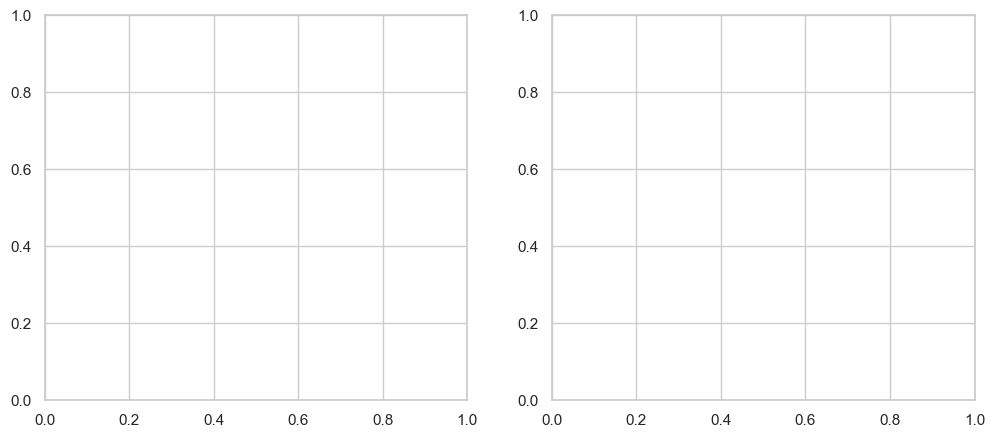

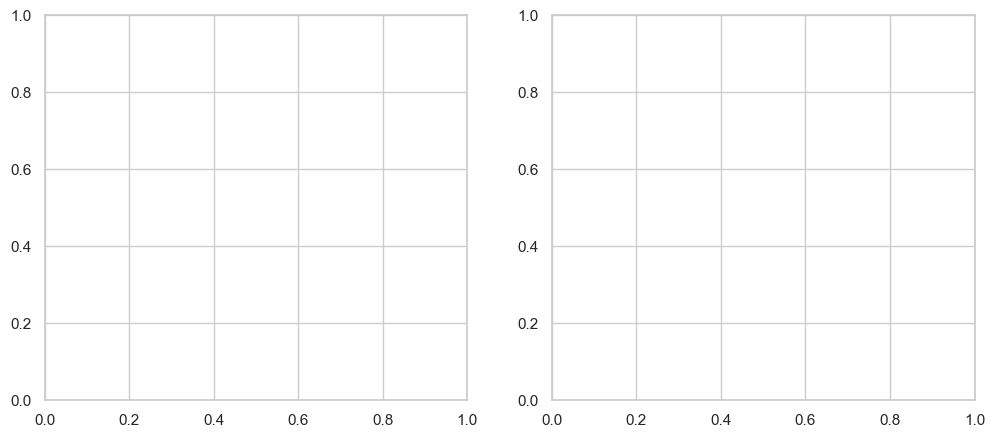

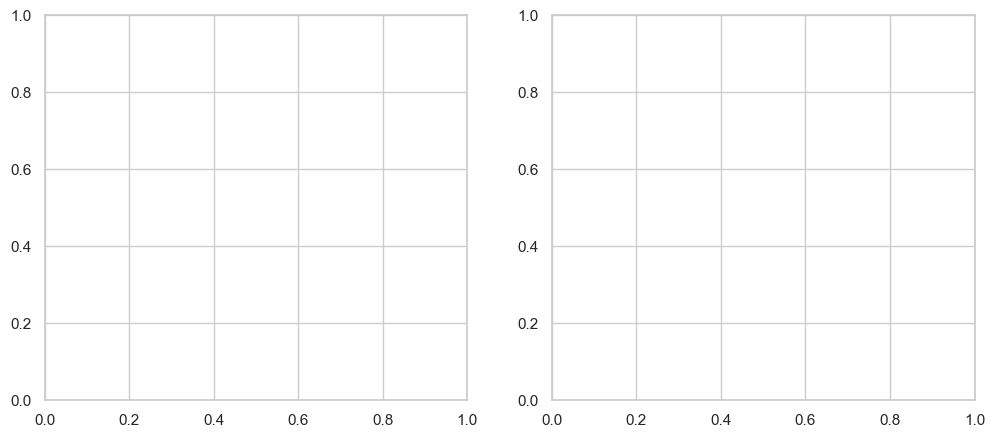

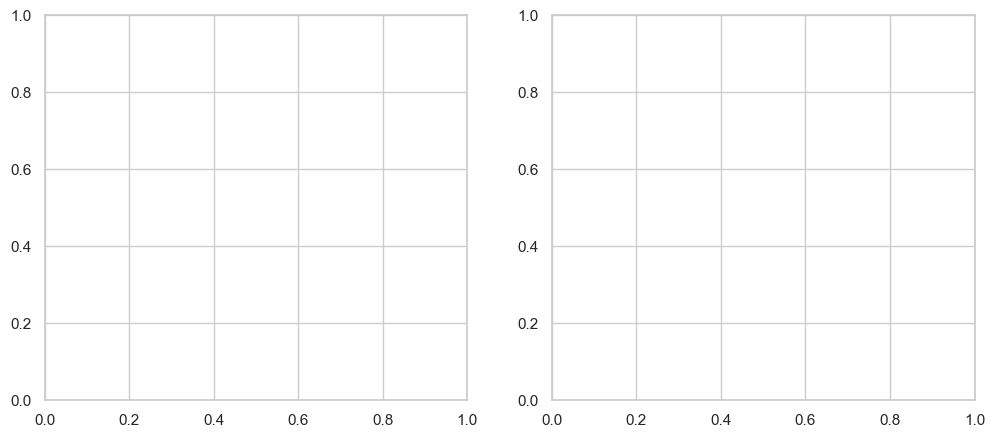

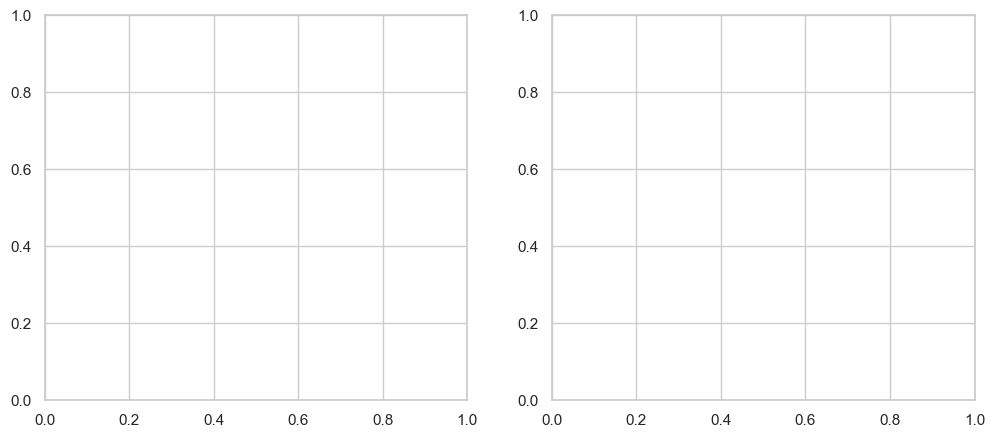

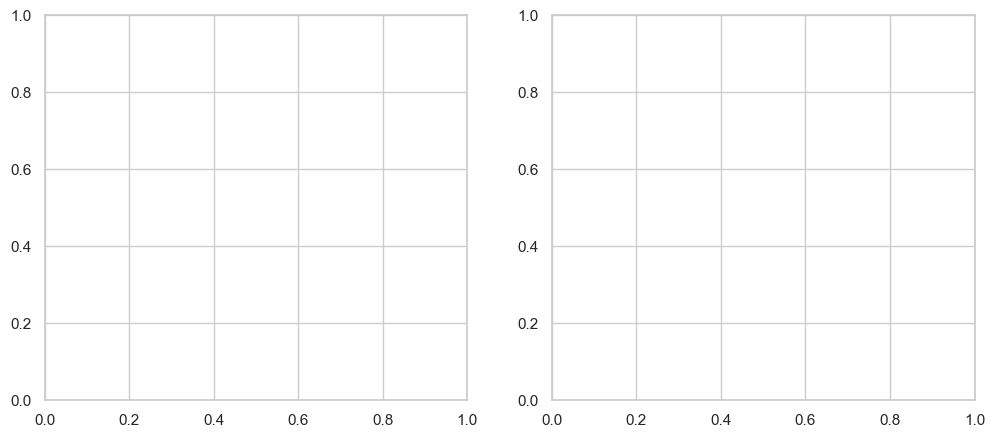

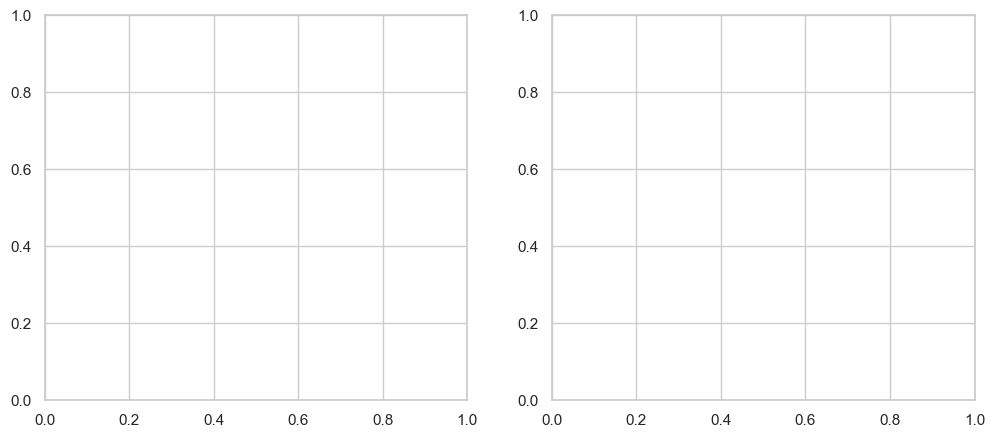

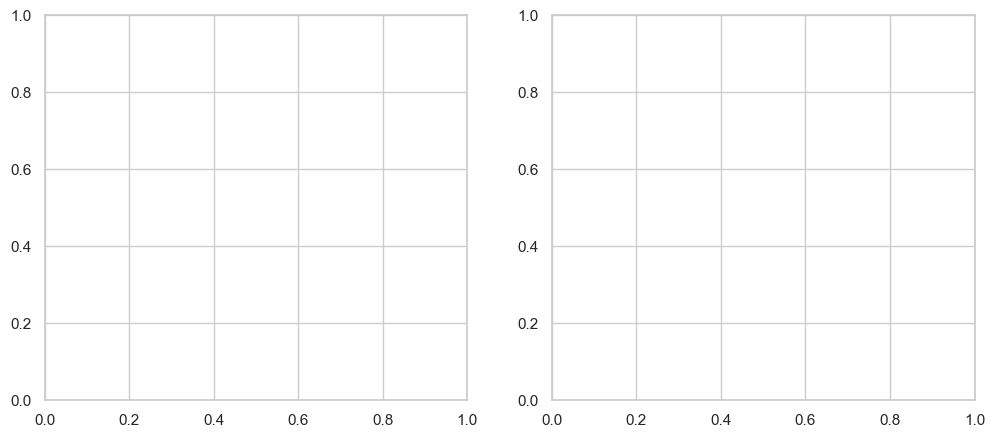

In [16]:
perform_eda()